In [1]:
import pandas as pd
import mols2grid
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import PandasTools
import MDAnalysis as mda
import prolif as plf
import seaborn as sns

Generate analogs with REINVENT4

In [3]:
!reinvent sampling.toml

/home/pwalters/anaconda3/envs/reinvent4/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
17:51:38 <INFO> Started REINVENT 4.0.28 (C) AstraZeneca 2017, 2023 on 2024-06-02
17:51:38 <INFO> Command line: /home/pwalters/anaconda3/envs/reinvent4/bin/reinvent sampling.toml
17:51:38 <INFO> User pwalters on host PWALTERS-LNX
17:51:38 <INFO> Python version 3.10.13
17:51:38 <INFO> PyTorch version 2.2.0+cu121, git 8ac9b20d4b090c213799e81acf48a55ea8d437d6
17:51:38 <INFO> PyTorch compiled with CUDA version 12.1
17:51:38 <INFO> RDKit version 2022.09.5
17:51:38 <INFO> Platform Linux-5.4.0-150-generic-x86_64-with-glibc2.27
17:51:38 <INFO> CUDA driver version 465.19.01
17:51:38 <INFO> Number of PyTorch CUDA devices 1
17:51:38 <INFO> Using CPU x86_64
17:51:38 <INFO> Writing JSON config file to /home/pwalters/softwa

Read the REINVENT4 output

In [4]:
df = pd.read_csv("sampling.csv")

View the molecules

In [5]:
mols2grid.display(df)

MolGridWidget()

Remove odd ring systems

In [6]:
ring_system_lookup = uru.RingSystemLookup.default()

In [7]:
df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)

In [8]:
df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

In [9]:
df_ok = df.query('min_freq > 100').copy()

How many molecules were removed? 

In [10]:
len(df),len(df_ok)

(460, 234)

Prepare the protein for docking with Spruce 

In [11]:
!/usr/local/openeye/bin/spruce -in data/5s18.pdb -out data/5s18.oedu

          :jGf:               
        :jGDDDDf:             
      ,fDDDGjLDDDf,           Spruce
    ,fDDLt:   :iLDDL;         
  ;fDLt:         :tfDG;       
,jft:   ,ijfffji,   :iff      
     .jGDDDDDDDDDGt.          
    ;GDDGt:''':tDDDG,         
   .DDDG:       :GDDG.        
   ;DDDj         tDDDi        
   ,DDDf         fDDD,         Copyright (c) 2019-2022
    LDDDt.     .fDDDj          OpenEye Scientific Software, Inc.
    .tDDDDfjtjfDDDGt          
      :ifGDDDDDGfi.            Version: 1.5.0.1
          .:::.                Built:   20220607
  ......................       OEChem version: 3.3.0.1 20220607
  DDDDDDDDDDDDDDDDDDDDDD       Platform: Ubuntu-18.04-g++7.5-x64
  DDDDDDDDDDDDDDDDDDDDDD  




  Licensed for the exclusive use of Relay Therapeutics, Inc..
  Licensed for use only in Camrbridge, MA.
  License expires on January 1, 2025.


Log written to : spruce_output.log
Run settings written to : spruce_settings.param


Write a SMILES file for conformer generation with Omega

In [12]:
df_ok['Name'] = [f"MOL{i:04d}" for i in range(0,len(df_ok))]

In [13]:
df_ok[["SMILES","Name"]].to_csv("data/analogs_rings_ok.smi",sep=" ",header=None, index=False)

Generate conformers with Omega

In [14]:
!/usr/local/openeye/bin/omega2 -in data/analogs_rings_ok.smi -out data/analogs_rings_ok.oeb -strictstereo false


          :jGf:             .d8888b. 88d8b.d8b. .d8888b. .d8888b. .d8888b.
        :jGDDDDf:           88'  `88 88'`88'`88 88ooood8 88'  `88 88'  `88
      ,fDDDGjLDDDf,         88.  .88 88  88  88 88.  ... 88.  .88 88.  .88
    ,fDDLt:   :iLDDL;       `88888P' dP  dP  dP `88888P' `8888P88 `88888P8
  ;fDLt:         :tfDG;                                       .88
,jft:   ,ijfffji,   :iff                                  d8888P
     .jGDDDDDDDDDGt.      
    ;GDDGt:''':tDDDG,          Copyright (c) 2004-2022
   .DDDG:       :GDDG.         OpenEye Scientific Software, Inc.
   ;DDDj         tDDDi    
   ,DDDf         fDDD,         Version: 4.2.0.1
    LDDDt.     .fDDDj          Built:   20220607
    .tDDDDfjtjfDDDGt           OEChem version: 3.3.0.1
      :ifGDDDDDGfi.            Platform: Ubuntu-18.04-g++7.5-x64
          .:::.                
  ......................       
  DDDDDDDDDDDDDDDDDDDDDD       
  DDDDDDDDDDDDDDDDDDDDDD       

Supported run modes:
  Single processor
  MPI Mu

Dock the conformers with Fred

In [15]:
!/usr/local/openeye/bin/fred -receptor data/5s18.oedu -dbase data/analogs_rings_ok.oeb -out data/analogs_rings_ok_docked.sdf

          :jGf:                .o88o.                          .o8
        :jGDDDDf:              888 `'                         '888
      ,fDDDGjLDDDf,           o888oo  oooo d8b  .ooooo.   .oooo888
    ,fDDLt:   :iLDDL;          888    `888""8P d88' `88b d88' `888
  ;fDLt:         :tfDG;        888     888     888ooo888 888   888
,jft:   ,ijfffji,   :iff       888     888     888    .o 888   888
     .jGDDDDDDDDDGt.          o888o   d888b    `Y8bod8P' `Y8bod88P'
    ;GDDGt:''':tDDDG,         
   .DDDG:       :GDDG.         Copyright (c) 2003-2022
   ;DDDj         tDDDi         OpenEye Scientific Software, Inc.
   ,DDDf         fDDD,         Version: 4.1.2.1
    LDDDt.     .fDDDj          Build date 20220607
    .tDDDDfjtjfDDDGt           
      :ifGDDDDDGfi.            Platform: Ubuntu-18.04-g++7.5-x64
          .:::.                Supported Run Modes:
  ......................         Single processor
  DDDDDDDDDDDDDDDDDDDDDD         MPI Multiprocessor
  DDDDDDDDDDDDDDDDDDDDDD     

Read the docked molecules

,FRED Chemgauss4 score,ID,ROMol
0,-9.637546,MOL0230_44,
1,-9.358097,MOL0170_5,
2,-9.222572,MOL0066_9,
3,-9.171738,MOL0110_5,
4,-8.918180,MOL0166_5,
...,...,...,...
229,-4.741882,MOL0075_1,
230,-4.650753,MOL0064_1,
231,-4.558986,MOL0039_1,
232,-4.471258,MOL0053_2,

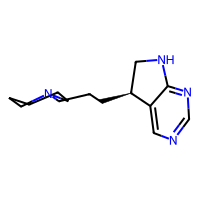
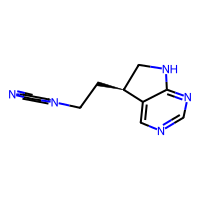
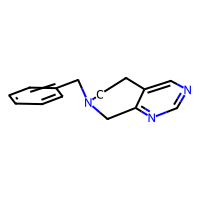
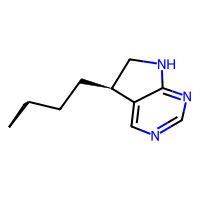
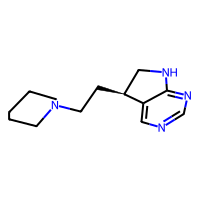
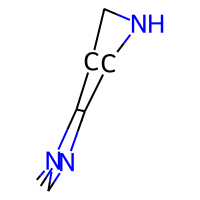
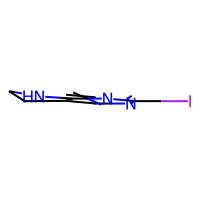
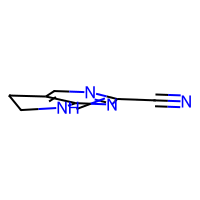
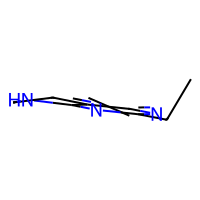
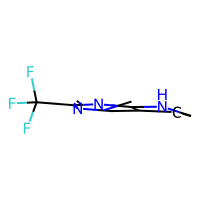

In [16]:
docked_df = PandasTools.LoadSDF("data/analogs_rings_ok_docked.sdf")
docked_df

In [17]:
PDB_FILEPATH = "data/5s18_protein.pdb"
SDF_FILEPATH = "data/analogs_rings_ok_docked.sdf"

In [18]:
fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(SDF_FILEPATH)
fp.run_from_iterable(suppl,prot,progress=True)
df = fp.to_dataframe()
df.columns = df.columns.droplevel(0)
df

  0%|          | 0/234 [00:00<?, ?it/s]

protein         ASP22.A                        ILE23.A                        \
interaction Hydrophobic HBDonor VdWContact Hydrophobic HBAcceptor VdWContact   
Frame                                                                          
0                 False   False       True        True      False      False   
1                 False   False      False       False      False      False   
2                 False   False      False       False      False      False   
3                 False   False      False       False      False      False   
4                 False   False      False       False      False      False   
...                 ...     ...        ...         ...        ...        ...   
229               False   False      False       False      False      False   
230               False    True       True        True       True       True   
231               False   False      False        True      False       True   
232               False   False      False       False      False      False   
233               False   False      False       False      False      False   

protein         ALA38.A               GLY48.A     VAL49.A  ...   PHE156.A  \
interaction Hydrophobic VdWContact VdWContact Hydrophobic  ... HBAcceptor   
Frame                                                      ...              
0                 False      False      False        True  ...      False   
1                 False      False       True        True  ...       True   
2                 False      False      False        True  ...       True   
3                 False      False       True        True  ...       True   
4                 False      False       True        True  ...       True   
...                 ...        ...        ...         ...  ...        ...   
229               False      False      False       False  ...       True   
230               False      False      False        True  ...      False   
231               False      False      False        True  ...      False   
232               False      False      False        True  ...      False   
233               False      False      False        True  ...      False   

protein                              ASP157.A                        \
interaction PiStacking VdWContact Hydrophobic HBAcceptor VdWContact   
Frame                                                                 
0                False       True       False      False      False   
1                False       True       False      False      False   
2                 True       True       False      False      False   
3                False       True       False      False      False   
4                False       True       False      False      False   
...                ...        ...         ...        ...        ...   
229              False       True        True      False       True   
230              False       True       False      False      False   
231              False       True       False      False      False   
232              False       True       False      False      False   
233              False       True       False      False      False   

protein        LEU160.A               DMS202.A             
interaction Hydrophobic VdWContact Hydrophobic VdWContact  
Frame                                                      
0                  True      False       False      False  
1                 False      False       False      False  
2                 False      False       False      False  
3                 False      False       False      False  
4                 False      False       False      False  
...                 ...        ...         ...        ...  
229                True      False       False       True  
230               False      False       False      False  
231               False      False       False      False  
232               False      False       False      False  
233               False  

Text(0.5, 54.249999999999986, 'Protein Interaction')

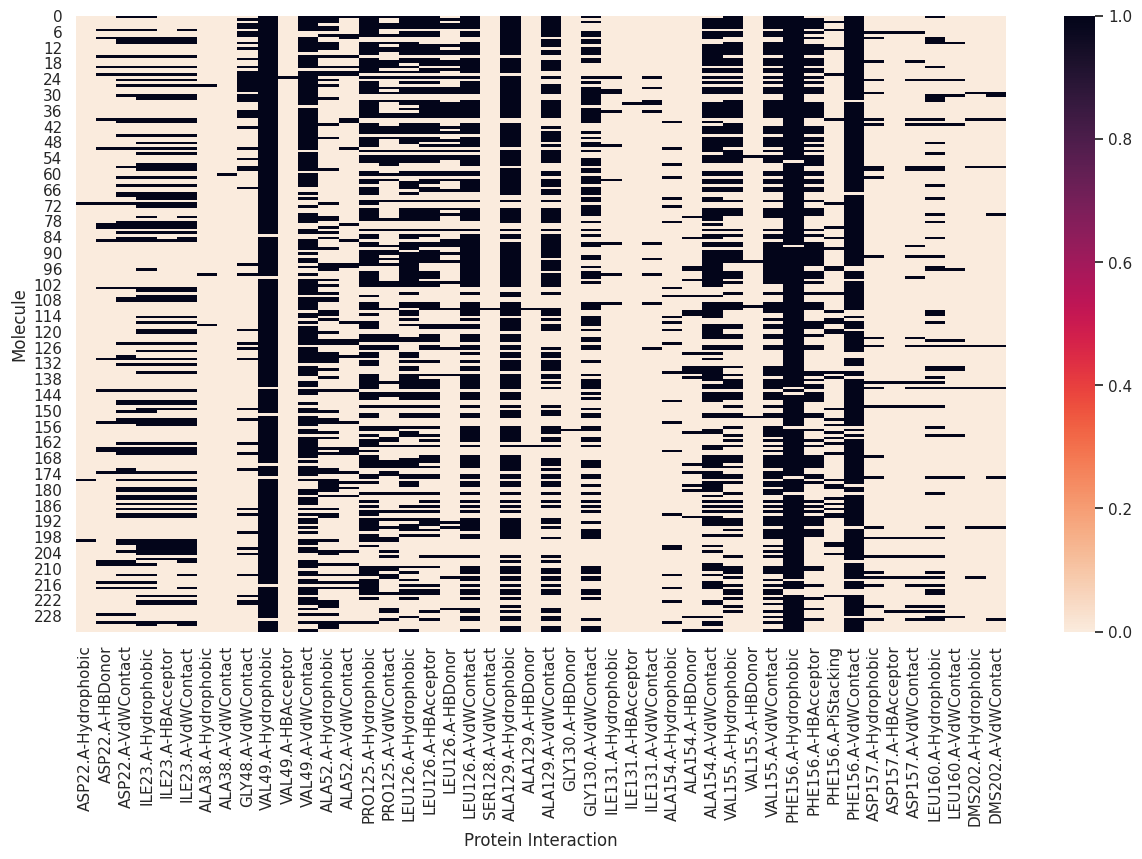

In [19]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(df,cmap=sns.cm.rocket_r)
ax.set_ylabel("Molecule")
ax.set_xlabel("Protein Interaction")